In [1]:
%load_ext autoreload
%autoreload 2

In [31]:
import sys
sys.path.append("/n/home12/binxuwang/Github/DiffusionLearningCurve")
from os.path import join
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from core.img_patch_stats_analysis_lib import compute_crossing_points, harmonic_mean, smooth_and_find_threshold_crossing
from core.trajectory_convergence_lib import analyze_and_plot_variance
from circuit_toolkit.plot_utils import saveallforms

In [24]:
from os.path import join
import torch
# from core.edm_dataset import load_dataset

def load_dataset(dataset_name, normalize=True):
    import sys
    sys.path.append("/n/home12/binxuwang/Github/edm")
    from training.dataset import TensorDataset, ImageFolderDataset
    edm_dataset_root = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Datasets/EDM_datasets/datasets"
    if dataset_name == "FFHQ":
        edm_ffhq64_path = join(edm_dataset_root, "ffhq-64x64.zip")
        dataset = ImageFolderDataset(edm_ffhq64_path)
        imgsize = 64
    elif dataset_name == "AFHQ":
        edm_afhq_path = join(edm_dataset_root, "afhqv2-64x64.zip")
        dataset = ImageFolderDataset(edm_afhq_path)
        imgsize = 64
    elif dataset_name == "CIFAR":
        edm_cifar_path = join(edm_dataset_root, "cifar10-32x32.zip")
        dataset = ImageFolderDataset(edm_cifar_path)
        imgsize = 32
    print(f"{dataset_name} dataset: {len(dataset)}")
    print(f"value range" , (dataset[0][0].max()), (dataset[0][0].min()))
    Xtsr_raw = torch.stack([torch.from_numpy(dataset[i][0]) for i in range(len(dataset))]) / 255.0
    if normalize:
        print("Normalizing dataset to [-1.0, 1.0]")
        Xtsr = (Xtsr_raw - 0.5) / 0.5
    else:
        Xtsr = Xtsr_raw
    return Xtsr, imgsize


### CIFAR10 lr small 1E-4

In [5]:
Xtsr, imgsize = load_dataset("CIFAR", normalize=True)
savedir = r"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiffusionSpectralLearningCurve/CIFAR10_UNet_CNN_EDM_3blocks_wide128_attn_pilot_fixednorm_smalllr"
sampledir = r"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiffusionSpectralLearningCurve/CIFAR10_UNet_CNN_EDM_3blocks_wide128_attn_pilot_fixednorm_smalllr/samples"
sample_store = sweep_and_create_sample_store(sampledir)

CIFAR dataset: 50000
value range 255 0
Normalizing dataset to [-1.0, 1.0]


  0%|          | 0/494 [00:00<?, ?it/s]

#### Patch 3x3 stride 1

In [59]:
patch_size, patch_stride = 3, 1
step_slice = sorted(sample_store.keys())
patch_mean, patch_cov, patch_eigval, patch_eigvec, mean_x_patch_sample_traj, cov_x_patch_sample_traj, diag_cov_x_patch_sample_true_eigenbasis_traj = \
     process_patch_mean_cov_statistics(Xtsr, sample_store, savedir, patch_size=patch_size, patch_stride=patch_stride, device="cuda", imgshape=(3, 32, 32))

patch_cov.shape: torch.Size([27]) computed on 50000 images


  0%|          | 0/494 [00:00<?, ?it/s]

Saved to /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiffusionSpectralLearningCurve/CIFAR10_UNet_CNN_EDM_3blocks_wide128_attn_pilot_fixednorm_smalllr/sample_patch_3x3_stride_1_cov_true_eigenbasis_diag_traj.pkl


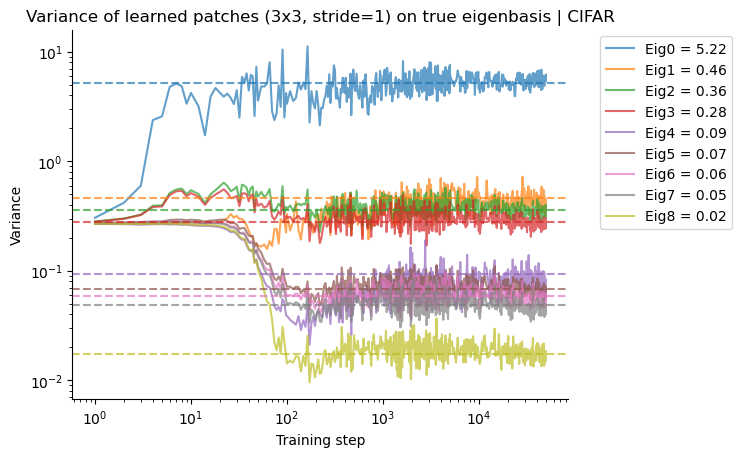

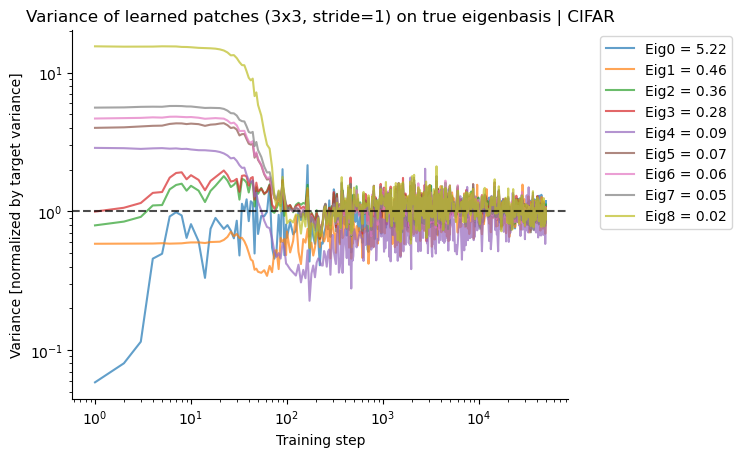

In [60]:
slice2plot = slice(0, 9, 1)
plot_variance_trajectories(step_slice, diag_cov_x_patch_sample_true_eigenbasis_traj, patch_eigval.cpu(), slice2plot,
                            patch_size=patch_size, patch_stride=patch_stride, savedir=savedir, dataset_name="CIFAR")

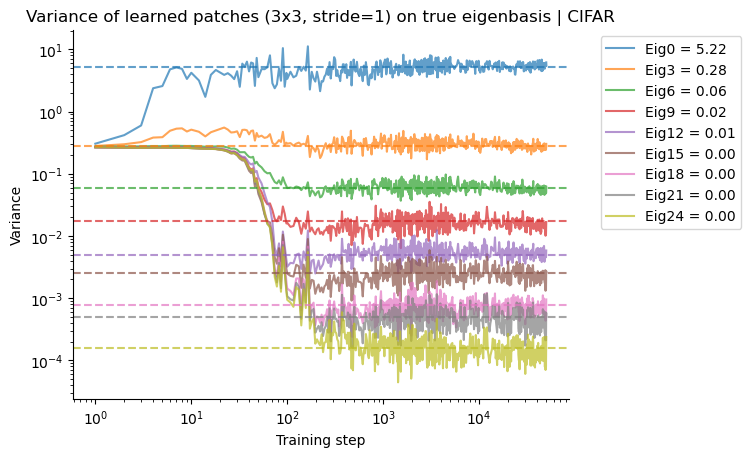

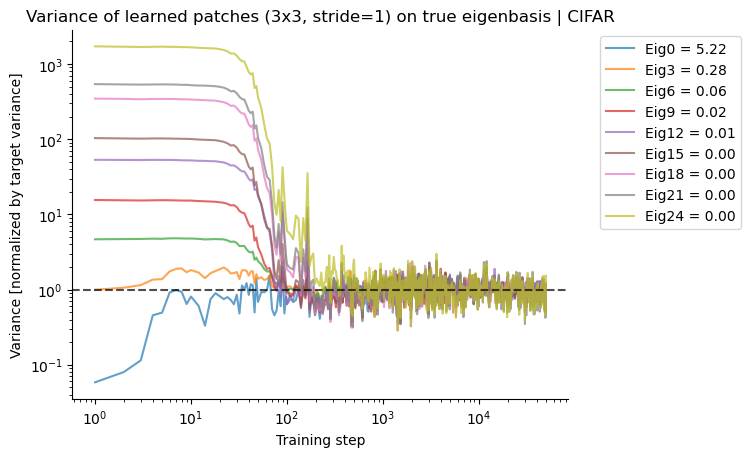

In [61]:
slice2plot = slice(0, 27, 3)
plot_variance_trajectories(step_slice, diag_cov_x_patch_sample_true_eigenbasis_traj, patch_eigval.cpu(), slice2plot,
                            patch_size=patch_size, patch_stride=patch_stride, savedir=savedir, dataset_name="CIFAR")

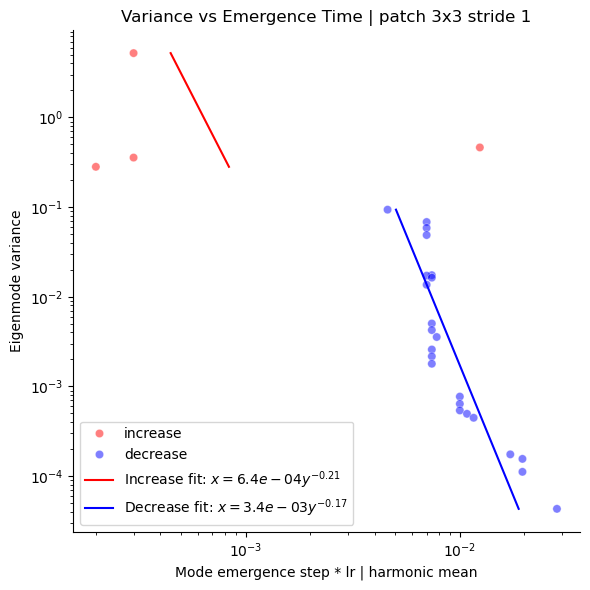

In [62]:
lr = 1e-4
lr_step_slice = np.array(step_slice) * lr
df = compute_crossing_points(patch_eigval, diag_cov_x_patch_sample_true_eigenbasis_traj, lr_step_slice, smooth_sigma=0.1, threshold_type="harmonic_mean", )
df.to_csv(f"{savedir}/synopsis_patch_{patch_size}x{patch_size}_stride_{patch_stride}_eigenmode_emergence_harmonic_mean_vs_variance.csv", index=False)
figh = analyze_and_plot_variance(df, x_col='emergence_step', y_col='Variance', 
                          hue_col='Direction', palette={"increase": "red", "decrease": "blue"}, 
                          log_x=True, log_y=True, figsize=(6, 6), fit_label_format='{direction} fit: $x = {a:.1e}y^{{{b:.2f}}}$', 
                          reverse_equation=True, annotate=False, annotate_offset=(0, 0), title=f'Variance vs Emergence Time | patch {patch_size}x{patch_size} stride {patch_stride}', 
                          xlabel='Mode emergence step * lr | harmonic mean', ylabel='Eigenmode variance', alpha=0.5, fit_line_kwargs=None, scatter_kwargs=None, ax=None)

saveallforms(savedir, f"synopsis_patch_{patch_size}x{patch_size}_stride_{patch_stride}_eigenmode_emergence_harmonic_mean_vs_variance_fitline_lr_reverse")

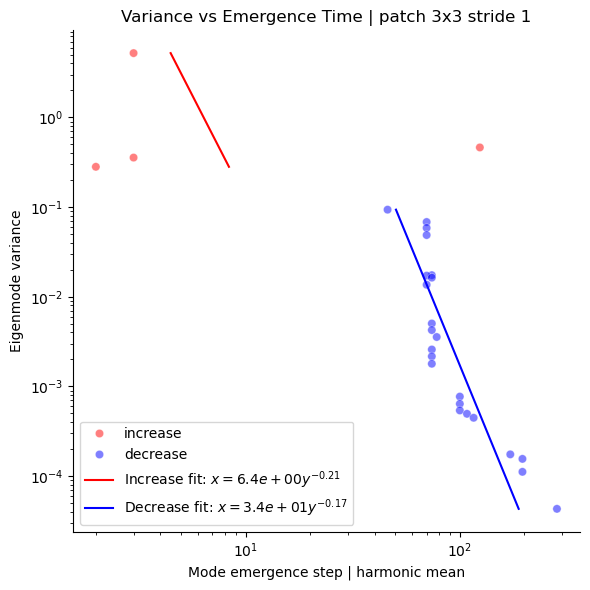

In [63]:
df = compute_crossing_points(patch_eigval, diag_cov_x_patch_sample_true_eigenbasis_traj, step_slice, smooth_sigma=0.1, threshold_type="harmonic_mean", )
df.to_csv(f"{savedir}/synopsis_patch_{patch_size}x{patch_size}_stride_{patch_stride}_eigenmode_emergence_harmonic_mean_vs_variance.csv", index=False)
figh = analyze_and_plot_variance(df, x_col='emergence_step', y_col='Variance', 
                          hue_col='Direction', palette={"increase": "red", "decrease": "blue"}, 
                          log_x=True, log_y=True, figsize=(6, 6), fit_label_format='{direction} fit: $x = {a:.1e}y^{{{b:.2f}}}$', 
                          reverse_equation=True, annotate=False, annotate_offset=(7, 0), title=f'Variance vs Emergence Time | patch {patch_size}x{patch_size} stride {patch_stride}', 
                          xlabel='Mode emergence step | harmonic mean', ylabel='Eigenmode variance', alpha=0.5, fit_line_kwargs=None, scatter_kwargs=None, ax=None)

saveallforms(savedir, f"synopsis_patch_{patch_size}x{patch_size}_stride_{patch_stride}_eigenmode_emergence_harmonic_mean_vs_variance_fitline_reverse")

#### Patch 6x6 stride 1

In [64]:
patch_size, patch_stride = 6, 1
step_slice = sorted(sample_store.keys())
patch_mean, patch_cov, patch_eigval, patch_eigvec, mean_x_patch_sample_traj, cov_x_patch_sample_traj, diag_cov_x_patch_sample_true_eigenbasis_traj = \
     process_patch_mean_cov_statistics(Xtsr, sample_store, savedir, patch_size=patch_size, patch_stride=patch_stride, device="cuda", imgshape=(3, 32, 32))

patch_cov.shape: torch.Size([108]) computed on 50000 images


  0%|          | 0/494 [00:00<?, ?it/s]

Saved to /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiffusionSpectralLearningCurve/CIFAR10_UNet_CNN_EDM_3blocks_wide128_attn_pilot_fixednorm_smalllr/sample_patch_6x6_stride_1_cov_true_eigenbasis_diag_traj.pkl


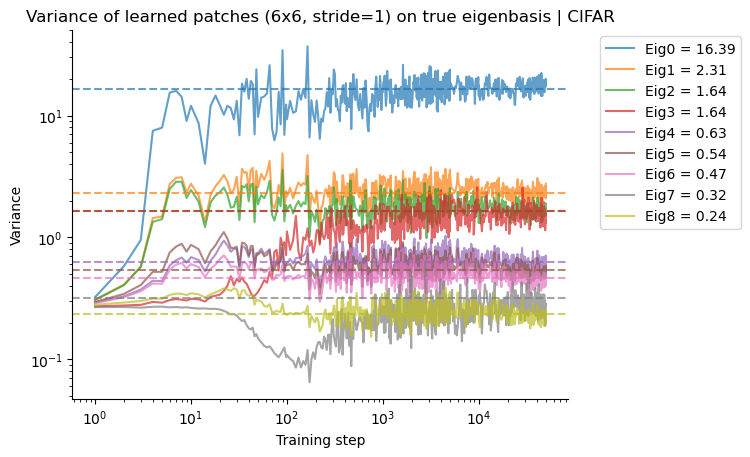

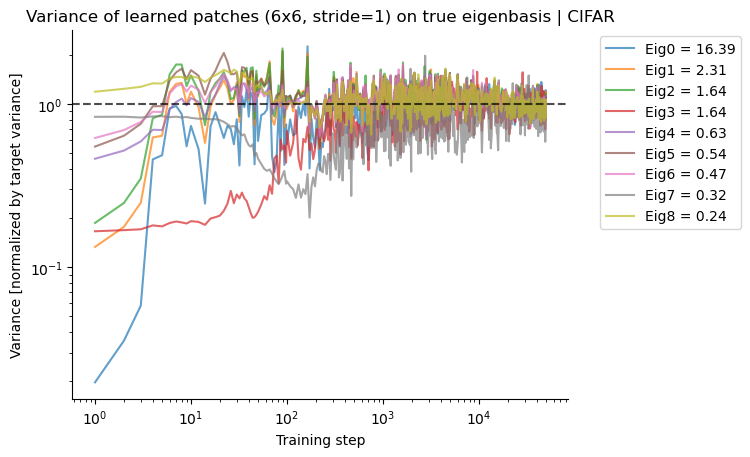

In [65]:
slice2plot = slice(0, 9, 1)
plot_variance_trajectories(step_slice, diag_cov_x_patch_sample_true_eigenbasis_traj, patch_eigval.cpu(), slice2plot,
                            patch_size=patch_size, patch_stride=patch_stride, savedir=savedir, dataset_name="CIFAR")

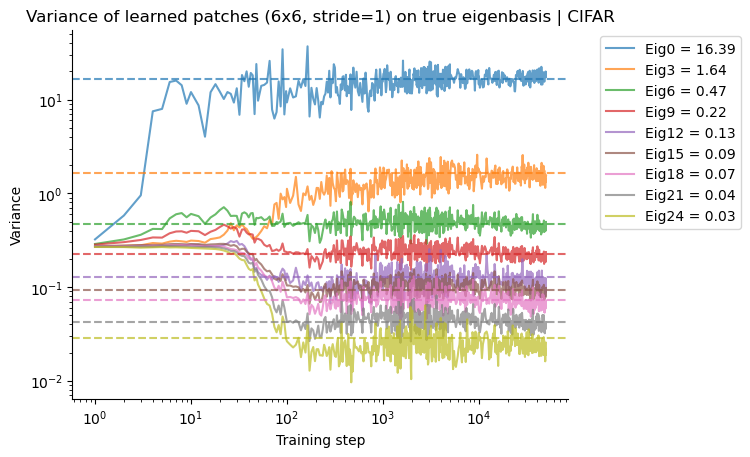

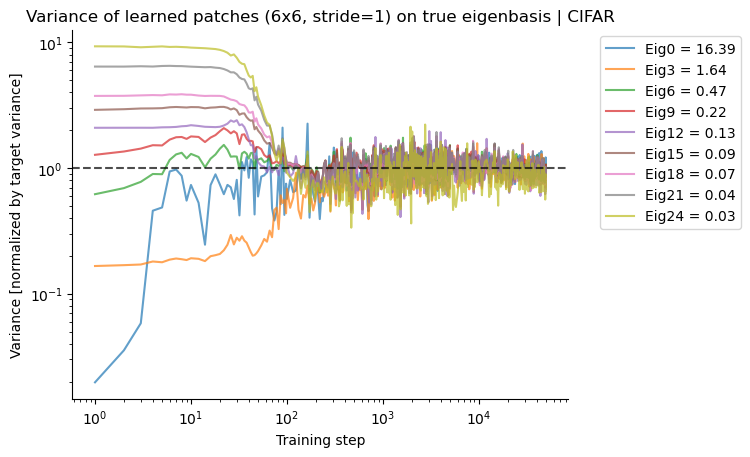

In [66]:
slice2plot = slice(0, 27, 3)
plot_variance_trajectories(step_slice, diag_cov_x_patch_sample_true_eigenbasis_traj, patch_eigval.cpu(), slice2plot,
                            patch_size=patch_size, patch_stride=patch_stride, savedir=savedir, dataset_name="CIFAR")

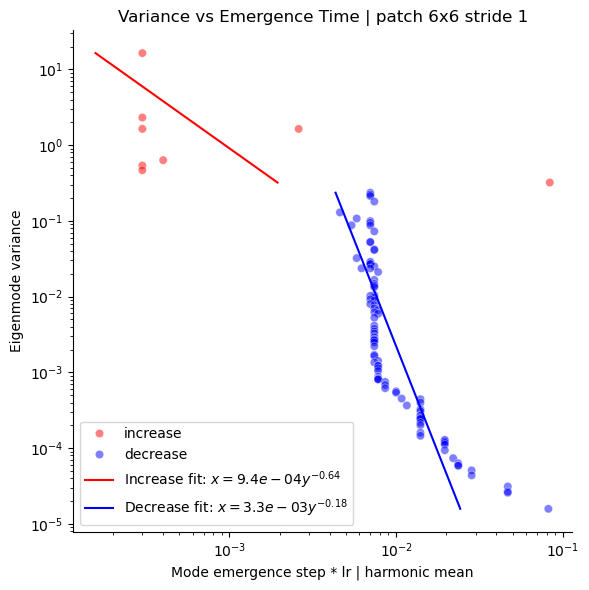

In [67]:
lr = 1e-4
lr_step_slice = np.array(step_slice) * lr
df = compute_crossing_points(patch_eigval, diag_cov_x_patch_sample_true_eigenbasis_traj, lr_step_slice, smooth_sigma=0.1, threshold_type="harmonic_mean", )
df.to_csv(f"{savedir}/synopsis_patch_{patch_size}x{patch_size}_stride_{patch_stride}_eigenmode_emergence_harmonic_mean_vs_variance.csv", index=False)
figh = analyze_and_plot_variance(df, x_col='emergence_step', y_col='Variance', 
                          hue_col='Direction', palette={"increase": "red", "decrease": "blue"}, 
                          log_x=True, log_y=True, figsize=(6, 6), fit_label_format='{direction} fit: $x = {a:.1e}y^{{{b:.2f}}}$', 
                          reverse_equation=True, annotate=False, annotate_offset=(0, 0), title=f'Variance vs Emergence Time | patch {patch_size}x{patch_size} stride {patch_stride}', 
                          xlabel='Mode emergence step * lr | harmonic mean', ylabel='Eigenmode variance', alpha=0.5, fit_line_kwargs=None, scatter_kwargs=None, ax=None)

saveallforms(savedir, f"synopsis_patch_{patch_size}x{patch_size}_stride_{patch_stride}_eigenmode_emergence_harmonic_mean_vs_variance_fitline_lr_reverse")

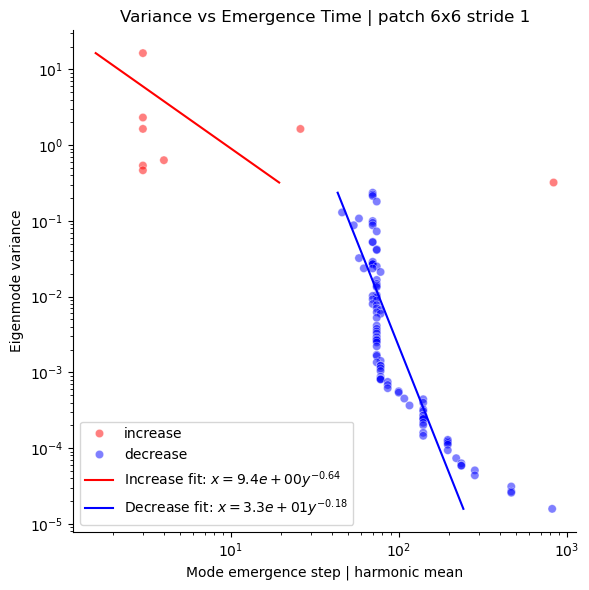

In [68]:
df = compute_crossing_points(patch_eigval, diag_cov_x_patch_sample_true_eigenbasis_traj, step_slice, smooth_sigma=0.1, threshold_type="harmonic_mean", )
df.to_csv(f"{savedir}/synopsis_patch_{patch_size}x{patch_size}_stride_{patch_stride}_eigenmode_emergence_harmonic_mean_vs_variance.csv", index=False)
figh = analyze_and_plot_variance(df, x_col='emergence_step', y_col='Variance', 
                          hue_col='Direction', palette={"increase": "red", "decrease": "blue"}, 
                          log_x=True, log_y=True, figsize=(6, 6), fit_label_format='{direction} fit: $x = {a:.1e}y^{{{b:.2f}}}$', 
                          reverse_equation=True, annotate=False, annotate_offset=(7, 0), title=f'Variance vs Emergence Time | patch {patch_size}x{patch_size} stride {patch_stride}', 
                          xlabel='Mode emergence step | harmonic mean', ylabel='Eigenmode variance', alpha=0.5, fit_line_kwargs=None, scatter_kwargs=None, ax=None)

saveallforms(savedir, f"synopsis_patch_{patch_size}x{patch_size}_stride_{patch_stride}_eigenmode_emergence_harmonic_mean_vs_variance_fitline_reverse")

#### Patch 6x6 stride 3

In [69]:
patch_size, patch_stride = 6, 3
step_slice = sorted(sample_store.keys())
patch_mean, patch_cov, patch_eigval, patch_eigvec, mean_x_patch_sample_traj, cov_x_patch_sample_traj, diag_cov_x_patch_sample_true_eigenbasis_traj = \
     process_patch_mean_cov_statistics(Xtsr, sample_store, savedir, patch_size=patch_size, patch_stride=patch_stride, device="cuda", imgshape=(3, 32, 32))

patch_cov.shape: torch.Size([108]) computed on 50000 images


  0%|          | 0/494 [00:00<?, ?it/s]

Saved to /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiffusionSpectralLearningCurve/CIFAR10_UNet_CNN_EDM_3blocks_wide128_attn_pilot_fixednorm_smalllr/sample_patch_6x6_stride_3_cov_true_eigenbasis_diag_traj.pkl


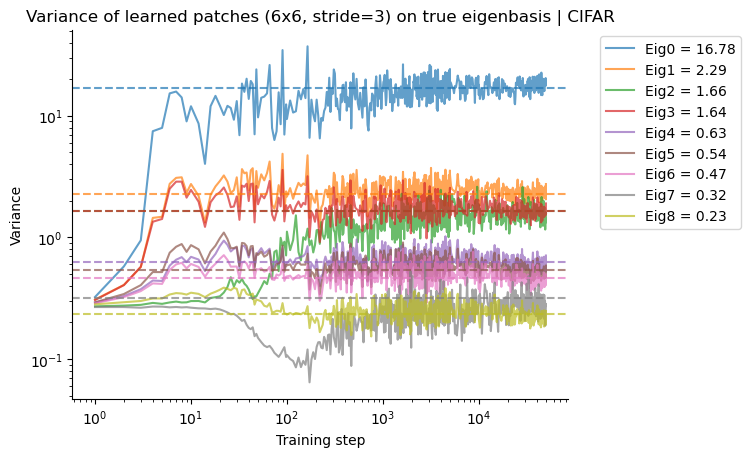

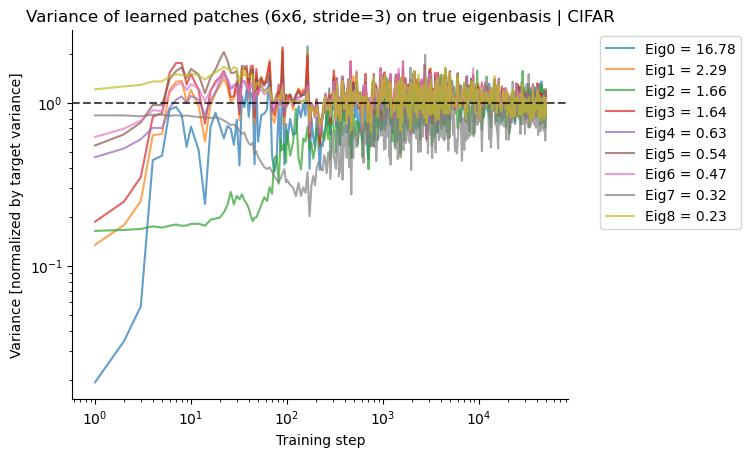

In [70]:
slice2plot = slice(0, 9, 1)
plot_variance_trajectories(step_slice, diag_cov_x_patch_sample_true_eigenbasis_traj, patch_eigval.cpu(), slice2plot,
                            patch_size=patch_size, patch_stride=patch_stride, savedir=savedir, dataset_name="CIFAR")

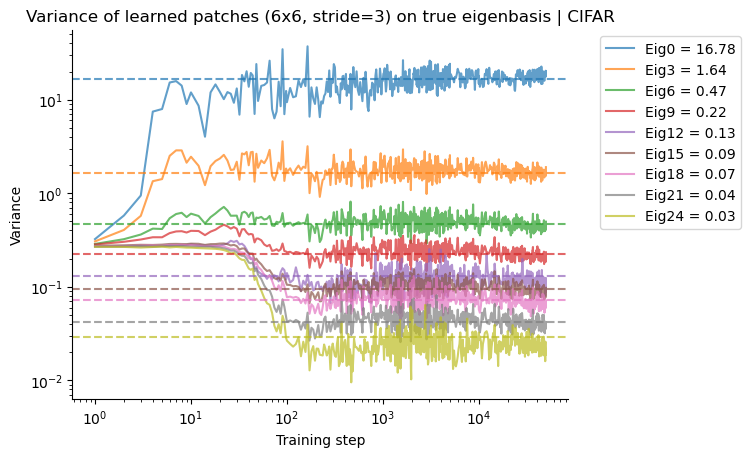

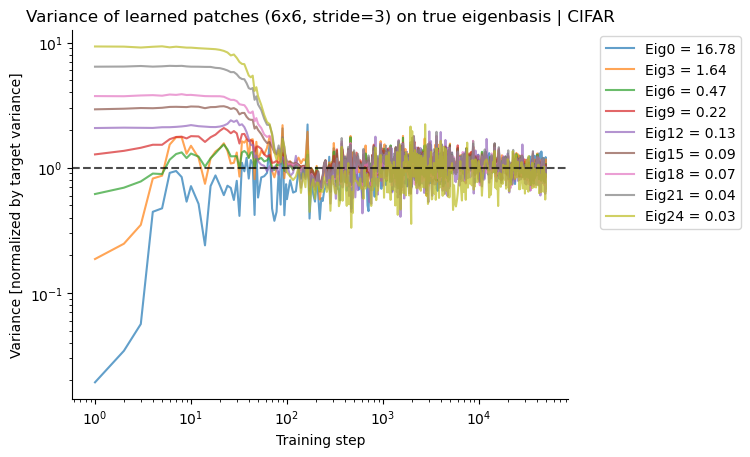

In [71]:
slice2plot = slice(0, 27, 3)
plot_variance_trajectories(step_slice, diag_cov_x_patch_sample_true_eigenbasis_traj, patch_eigval.cpu(), slice2plot,
                            patch_size=patch_size, patch_stride=patch_stride, savedir=savedir, dataset_name="CIFAR")

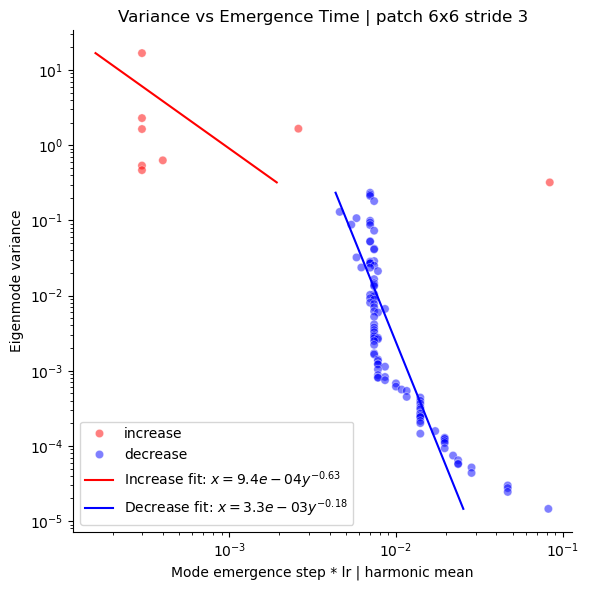

In [72]:
lr = 1e-4
lr_step_slice = np.array(step_slice) * lr
df = compute_crossing_points(patch_eigval, diag_cov_x_patch_sample_true_eigenbasis_traj, lr_step_slice, smooth_sigma=0.1, threshold_type="harmonic_mean", )
df.to_csv(f"{savedir}/synopsis_patch_{patch_size}x{patch_size}_stride_{patch_stride}_eigenmode_emergence_harmonic_mean_vs_variance.csv", index=False)
figh = analyze_and_plot_variance(df, x_col='emergence_step', y_col='Variance', 
                          hue_col='Direction', palette={"increase": "red", "decrease": "blue"}, 
                          log_x=True, log_y=True, figsize=(6, 6), fit_label_format='{direction} fit: $x = {a:.1e}y^{{{b:.2f}}}$', 
                          reverse_equation=True, annotate=False, annotate_offset=(0, 0), title=f'Variance vs Emergence Time | patch {patch_size}x{patch_size} stride {patch_stride}', 
                          xlabel='Mode emergence step * lr | harmonic mean', ylabel='Eigenmode variance', alpha=0.5, fit_line_kwargs=None, scatter_kwargs=None, ax=None)

saveallforms(savedir, f"synopsis_patch_{patch_size}x{patch_size}_stride_{patch_stride}_eigenmode_emergence_harmonic_mean_vs_variance_fitline_lr_reverse")

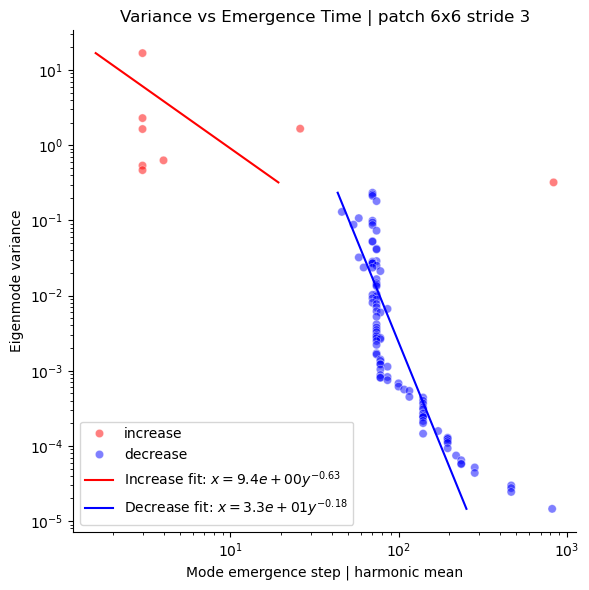

In [73]:
df = compute_crossing_points(patch_eigval, diag_cov_x_patch_sample_true_eigenbasis_traj, step_slice, smooth_sigma=0.1, threshold_type="harmonic_mean", )
df.to_csv(f"{savedir}/synopsis_patch_{patch_size}x{patch_size}_stride_{patch_stride}_eigenmode_emergence_harmonic_mean_vs_variance.csv", index=False)
figh = analyze_and_plot_variance(df, x_col='emergence_step', y_col='Variance', 
                          hue_col='Direction', palette={"increase": "red", "decrease": "blue"}, 
                          log_x=True, log_y=True, figsize=(6, 6), fit_label_format='{direction} fit: $x = {a:.1e}y^{{{b:.2f}}}$', 
                          reverse_equation=True, annotate=False, annotate_offset=(7, 0), title=f'Variance vs Emergence Time | patch {patch_size}x{patch_size} stride {patch_stride}', 
                          xlabel='Mode emergence step | harmonic mean', ylabel='Eigenmode variance', alpha=0.5, fit_line_kwargs=None, scatter_kwargs=None, ax=None)

saveallforms(savedir, f"synopsis_patch_{patch_size}x{patch_size}_stride_{patch_stride}_eigenmode_emergence_harmonic_mean_vs_variance_fitline_reverse")

#### Patch 9x9 stride 3

In [74]:
patch_size, patch_stride = 9, 3
step_slice = sorted(sample_store.keys())
patch_mean, patch_cov, patch_eigval, patch_eigvec, mean_x_patch_sample_traj, cov_x_patch_sample_traj, diag_cov_x_patch_sample_true_eigenbasis_traj = \
     process_patch_mean_cov_statistics(Xtsr, sample_store, savedir, patch_size=patch_size, patch_stride=patch_stride, device="cuda", imgshape=(3, 32, 32))

patch_cov.shape: torch.Size([243]) computed on 50000 images


  0%|          | 0/494 [00:00<?, ?it/s]

Saved to /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiffusionSpectralLearningCurve/CIFAR10_UNet_CNN_EDM_3blocks_wide128_attn_pilot_fixednorm_smalllr/sample_patch_9x9_stride_3_cov_true_eigenbasis_diag_traj.pkl


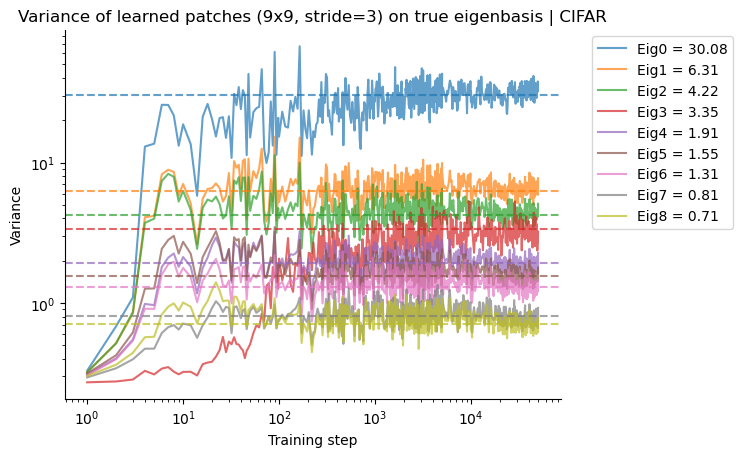

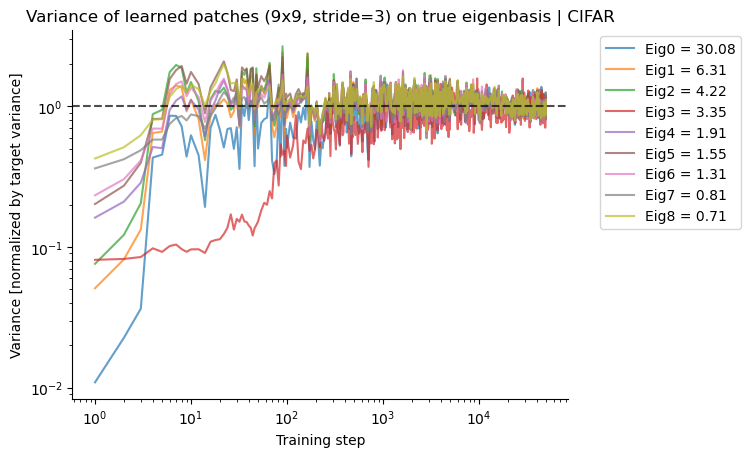

In [75]:
slice2plot = slice(0, 9, 1)
plot_variance_trajectories(step_slice, diag_cov_x_patch_sample_true_eigenbasis_traj, patch_eigval.cpu(), slice2plot,
                            patch_size=patch_size, patch_stride=patch_stride, savedir=savedir, dataset_name="CIFAR")

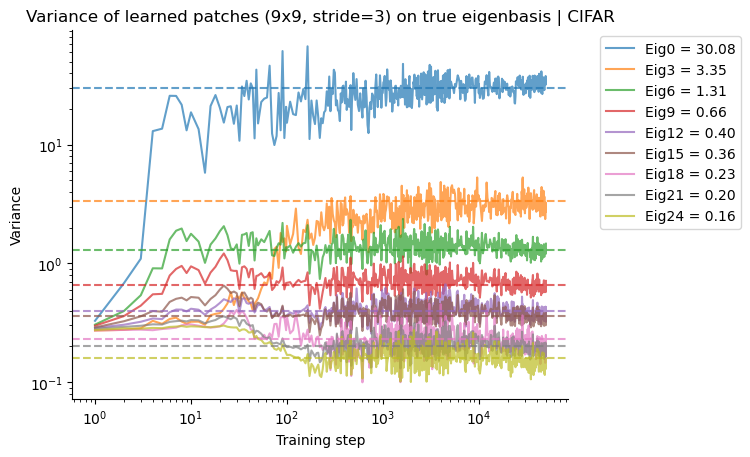

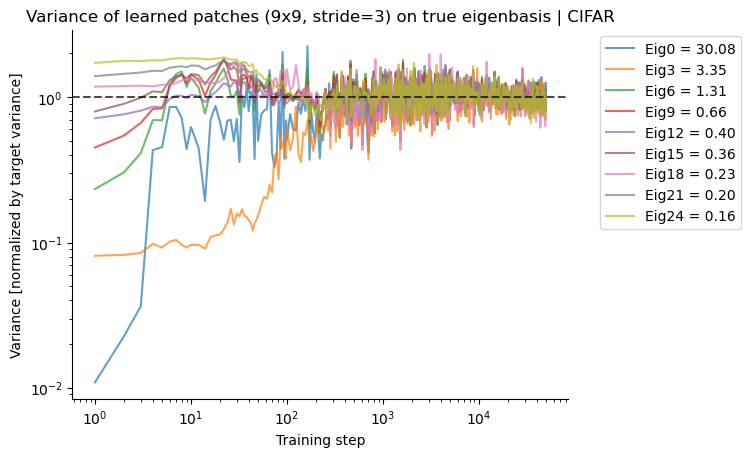

In [76]:
slice2plot = slice(0, 27, 3)
plot_variance_trajectories(step_slice, diag_cov_x_patch_sample_true_eigenbasis_traj, patch_eigval.cpu(), slice2plot,
                            patch_size=patch_size, patch_stride=patch_stride, savedir=savedir, dataset_name="CIFAR")

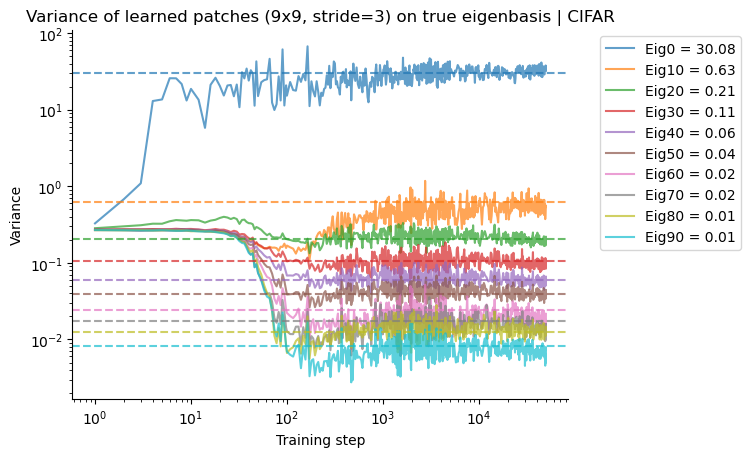

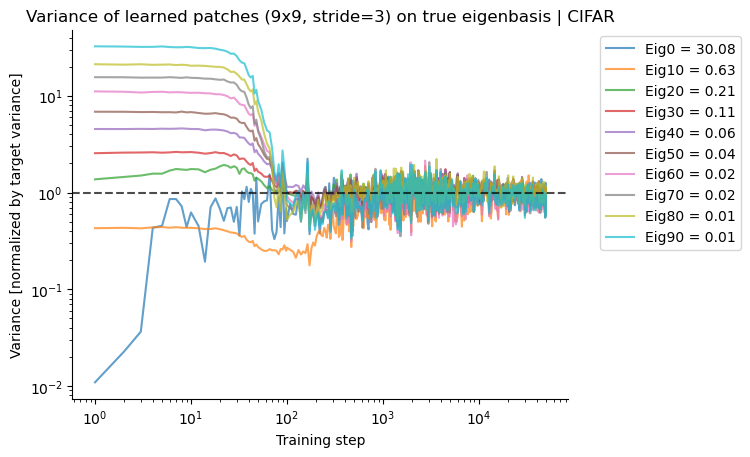

In [77]:
slice2plot = slice(0, 100, 10)
plot_variance_trajectories(step_slice, diag_cov_x_patch_sample_true_eigenbasis_traj, patch_eigval.cpu(), slice2plot,
                            patch_size=patch_size, patch_stride=patch_stride, savedir=savedir, dataset_name="CIFAR")

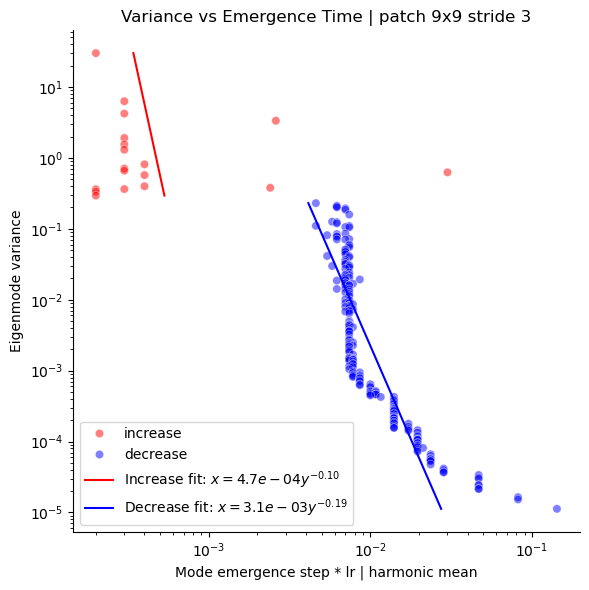

In [78]:
lr = 1e-4
lr_step_slice = np.array(step_slice) * lr
df = compute_crossing_points(patch_eigval, diag_cov_x_patch_sample_true_eigenbasis_traj, lr_step_slice, smooth_sigma=0.1, threshold_type="harmonic_mean", )
df.to_csv(f"{savedir}/synopsis_patch_{patch_size}x{patch_size}_stride_{patch_stride}_eigenmode_emergence_harmonic_mean_vs_variance.csv", index=False)
figh = analyze_and_plot_variance(df, x_col='emergence_step', y_col='Variance', 
                          hue_col='Direction', palette={"increase": "red", "decrease": "blue"}, 
                          log_x=True, log_y=True, figsize=(6, 6), fit_label_format='{direction} fit: $x = {a:.1e}y^{{{b:.2f}}}$', 
                          reverse_equation=True, annotate=False, annotate_offset=(0, 0), title=f'Variance vs Emergence Time | patch {patch_size}x{patch_size} stride {patch_stride}', 
                          xlabel='Mode emergence step * lr | harmonic mean', ylabel='Eigenmode variance', alpha=0.5, fit_line_kwargs=None, scatter_kwargs=None, ax=None)

saveallforms(savedir, f"synopsis_patch_{patch_size}x{patch_size}_stride_{patch_stride}_eigenmode_emergence_harmonic_mean_vs_variance_fitline_lr_reverse")

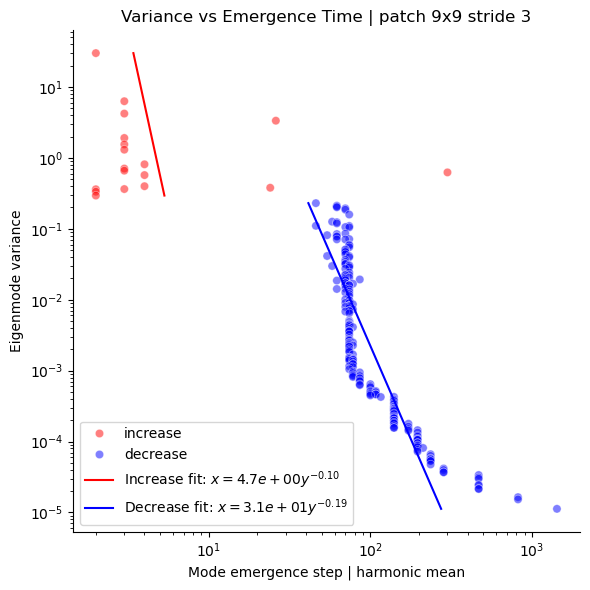

In [79]:
df = compute_crossing_points(patch_eigval, diag_cov_x_patch_sample_true_eigenbasis_traj, step_slice, smooth_sigma=0.1, threshold_type="harmonic_mean", )
df.to_csv(f"{savedir}/synopsis_patch_{patch_size}x{patch_size}_stride_{patch_stride}_eigenmode_emergence_harmonic_mean_vs_variance.csv", index=False)
figh = analyze_and_plot_variance(df, x_col='emergence_step', y_col='Variance', 
                          hue_col='Direction', palette={"increase": "red", "decrease": "blue"}, 
                          log_x=True, log_y=True, figsize=(6, 6), fit_label_format='{direction} fit: $x = {a:.1e}y^{{{b:.2f}}}$', 
                          reverse_equation=True, annotate=False, annotate_offset=(7, 0), title=f'Variance vs Emergence Time | patch {patch_size}x{patch_size} stride {patch_stride}', 
                          xlabel='Mode emergence step | harmonic mean', ylabel='Eigenmode variance', alpha=0.5, fit_line_kwargs=None, scatter_kwargs=None, ax=None)

saveallforms(savedir, f"synopsis_patch_{patch_size}x{patch_size}_stride_{patch_stride}_eigenmode_emergence_harmonic_mean_vs_variance_fitline_reverse")

### AFHQ

In [80]:
Xtsr, imgsize = load_dataset("AFHQ", normalize=True)
savedir = r"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiffusionSpectralLearningCurve/AFHQ_UNet_CNN_EDM_4blocks_wide64_attn_pilot_fixednorm"
sampledir = r"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiffusionSpectralLearningCurve/AFHQ_UNet_CNN_EDM_4blocks_wide64_attn_pilot_fixednorm/samples"
sample_store = sweep_and_create_sample_store(sampledir)

AFHQ dataset: 15803
value range 250 0
Normalizing dataset to [-1.0, 1.0]


  0%|          | 0/494 [00:00<?, ?it/s]

#### Patch 3x3 stride 1

In [100]:
patch_size, patch_stride = 3, 1
step_slice = sorted(sample_store.keys())
patch_mean, patch_cov, patch_eigval, patch_eigvec, mean_x_patch_sample_traj, cov_x_patch_sample_traj, diag_cov_x_patch_sample_true_eigenbasis_traj = \
     process_patch_mean_cov_statistics(Xtsr, sample_store, savedir, patch_size=patch_size, patch_stride=patch_stride, device="cuda", imgshape=(3, 64, 64))

patch_cov.shape: torch.Size([27]) computed on 15803 images


  0%|          | 0/494 [00:00<?, ?it/s]

Saved to /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiffusionSpectralLearningCurve/AFHQ_UNet_CNN_EDM_4blocks_wide64_attn_pilot_fixednorm/sample_patch_3x3_stride_1_cov_true_eigenbasis_diag_traj.pkl


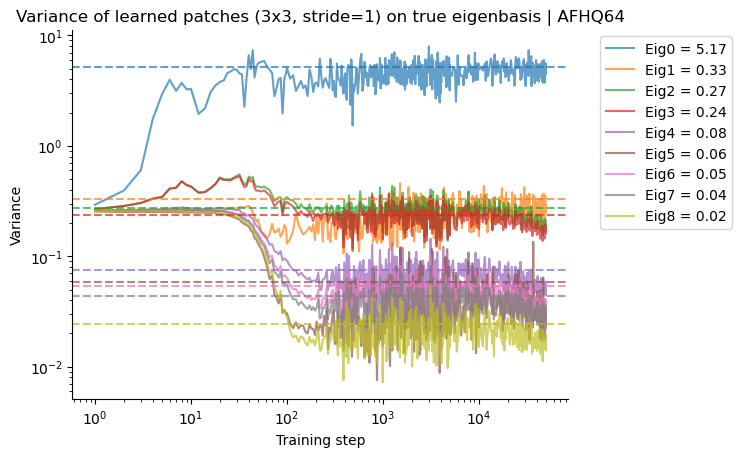

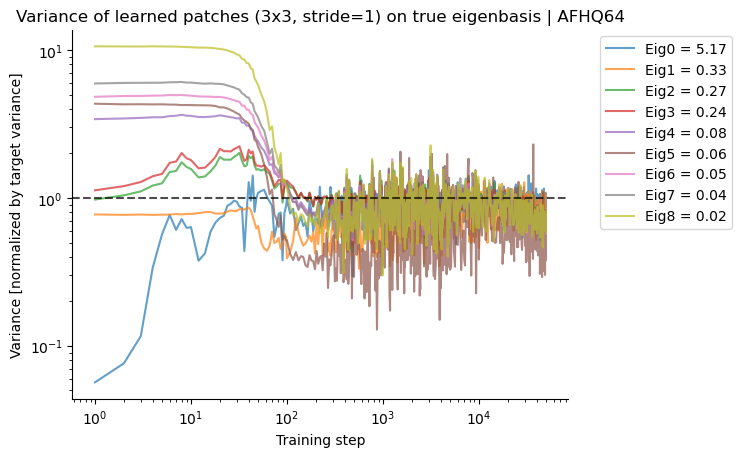

In [101]:
slice2plot = slice(0, 9, 1)
plot_variance_trajectories(step_slice, diag_cov_x_patch_sample_true_eigenbasis_traj, patch_eigval.cpu(), slice2plot,
                            patch_size=patch_size, patch_stride=patch_stride, savedir=savedir, dataset_name="AFHQ64")

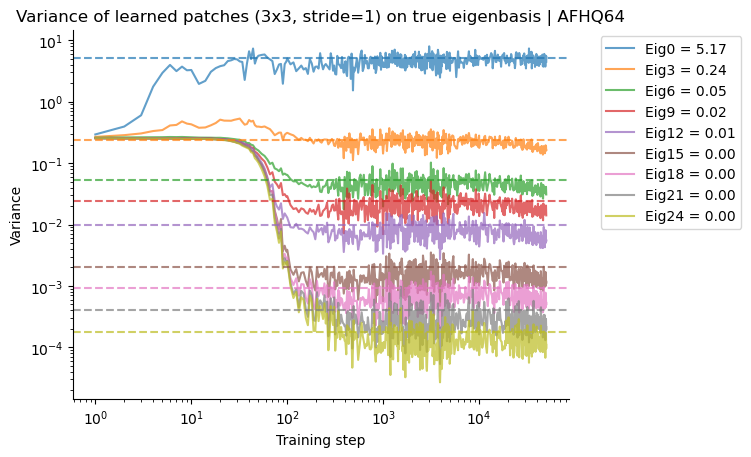

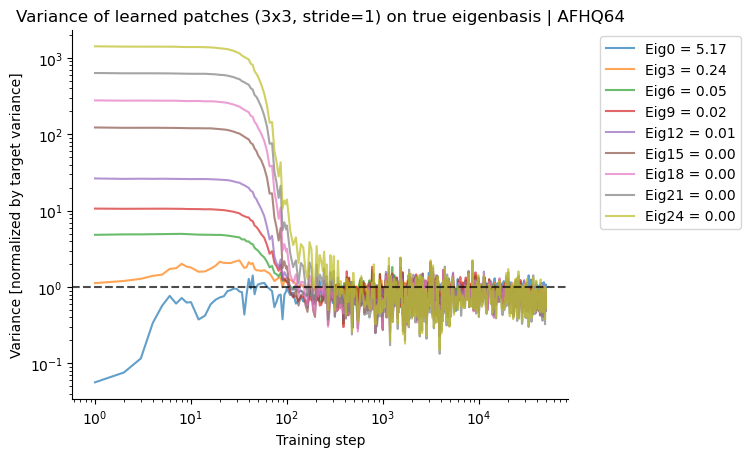

In [102]:
slice2plot = slice(0, 27, 3)
plot_variance_trajectories(step_slice, diag_cov_x_patch_sample_true_eigenbasis_traj, patch_eigval.cpu(), slice2plot,
                            patch_size=patch_size, patch_stride=patch_stride, savedir=savedir, dataset_name="AFHQ64")

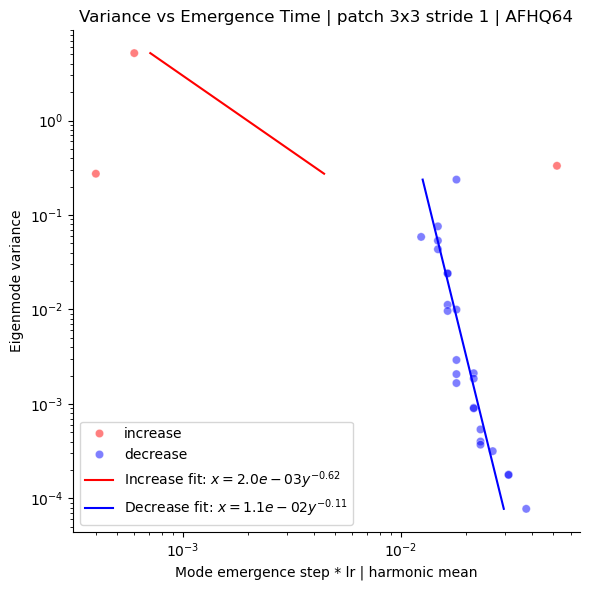

In [103]:
lr = 2e-4
lr_step_slice = np.array(step_slice) * lr
df = compute_crossing_points(patch_eigval, diag_cov_x_patch_sample_true_eigenbasis_traj, lr_step_slice, smooth_sigma=0.1, threshold_type="harmonic_mean", )
df.to_csv(f"{savedir}/synopsis_patch_{patch_size}x{patch_size}_stride_{patch_stride}_eigenmode_emergence_harmonic_mean_vs_variance.csv", index=False)
figh = analyze_and_plot_variance(df, x_col='emergence_step', y_col='Variance', 
                          hue_col='Direction', palette={"increase": "red", "decrease": "blue"}, 
                          log_x=True, log_y=True, figsize=(6, 6), fit_label_format='{direction} fit: $x = {a:.1e}y^{{{b:.2f}}}$', 
                          reverse_equation=True, annotate=False, annotate_offset=(0, 0), title=f'Variance vs Emergence Time | patch {patch_size}x{patch_size} stride {patch_stride} | AFHQ64', 
                          xlabel='Mode emergence step * lr | harmonic mean', ylabel='Eigenmode variance', alpha=0.5, fit_line_kwargs=None, scatter_kwargs=None, ax=None)

saveallforms(savedir, f"synopsis_patch_{patch_size}x{patch_size}_stride_{patch_stride}_eigenmode_emergence_harmonic_mean_vs_variance_fitline_lr_reverse")

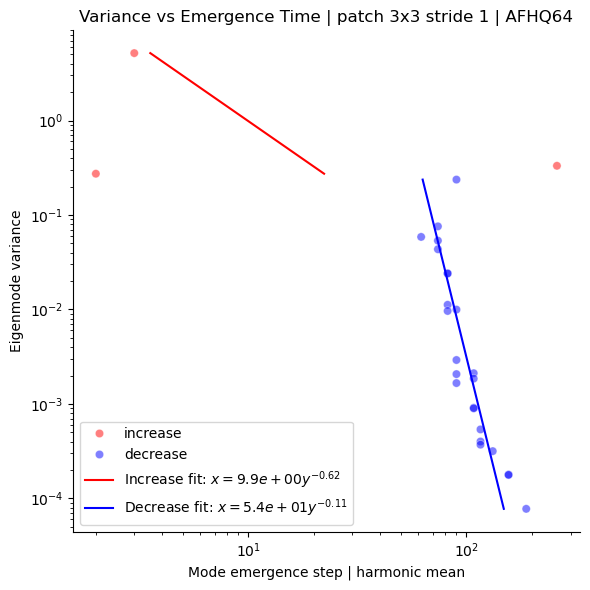

In [104]:
df = compute_crossing_points(patch_eigval, diag_cov_x_patch_sample_true_eigenbasis_traj, step_slice, smooth_sigma=0.1, threshold_type="harmonic_mean", )
df.to_csv(f"{savedir}/synopsis_patch_{patch_size}x{patch_size}_stride_{patch_stride}_eigenmode_emergence_harmonic_mean_vs_variance.csv", index=False)
figh = analyze_and_plot_variance(df, x_col='emergence_step', y_col='Variance', 
                          hue_col='Direction', palette={"increase": "red", "decrease": "blue"}, 
                          log_x=True, log_y=True, figsize=(6, 6), fit_label_format='{direction} fit: $x = {a:.1e}y^{{{b:.2f}}}$', 
                          reverse_equation=True, annotate=False, annotate_offset=(7, 0), title=f'Variance vs Emergence Time | patch {patch_size}x{patch_size} stride {patch_stride} | AFHQ64', 
                          xlabel='Mode emergence step | harmonic mean', ylabel='Eigenmode variance', alpha=0.5, fit_line_kwargs=None, scatter_kwargs=None, ax=None)

saveallforms(savedir, f"synopsis_patch_{patch_size}x{patch_size}_stride_{patch_stride}_eigenmode_emergence_harmonic_mean_vs_variance_fitline_reverse")

#### Patch 6x6 stride 3

In [105]:
patch_size, patch_stride = 6, 3
step_slice = sorted(sample_store.keys())
patch_mean, patch_cov, patch_eigval, patch_eigvec, mean_x_patch_sample_traj, cov_x_patch_sample_traj, diag_cov_x_patch_sample_true_eigenbasis_traj = \
     process_patch_mean_cov_statistics(Xtsr, sample_store, savedir, patch_size=patch_size, patch_stride=patch_stride, device="cuda", imgshape=(3, 64, 64))

patch_cov.shape: torch.Size([108]) computed on 15803 images


  0%|          | 0/494 [00:00<?, ?it/s]

Saved to /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiffusionSpectralLearningCurve/AFHQ_UNet_CNN_EDM_4blocks_wide64_attn_pilot_fixednorm/sample_patch_6x6_stride_3_cov_true_eigenbasis_diag_traj.pkl


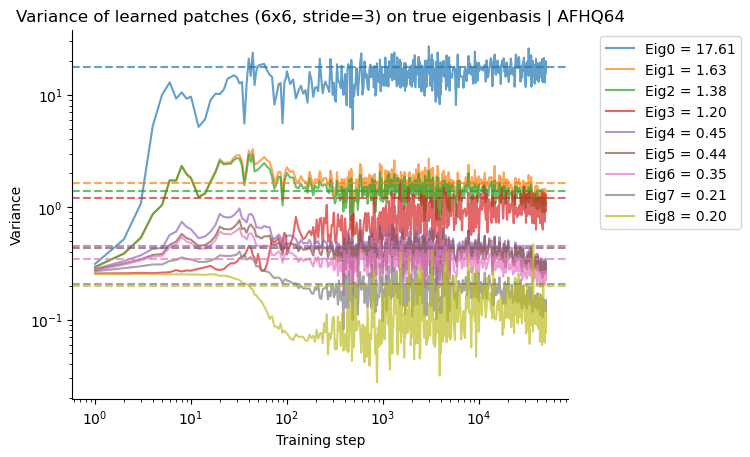

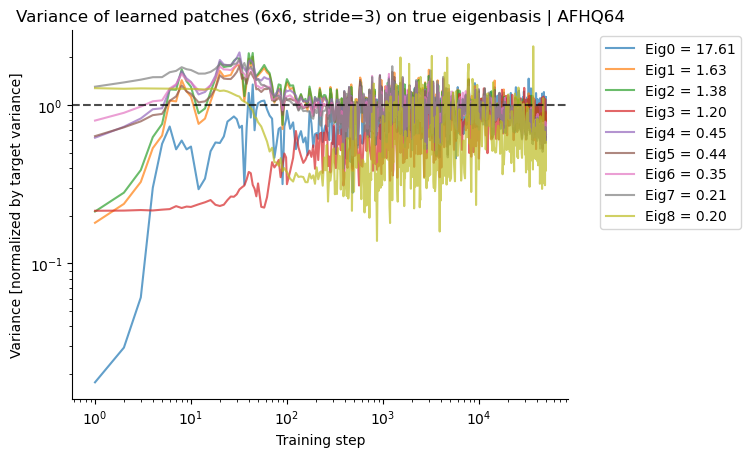

In [106]:
slice2plot = slice(0, 9, 1)
plot_variance_trajectories(step_slice, diag_cov_x_patch_sample_true_eigenbasis_traj, patch_eigval.cpu(), slice2plot,
                            patch_size=patch_size, patch_stride=patch_stride, savedir=savedir, dataset_name="AFHQ64")

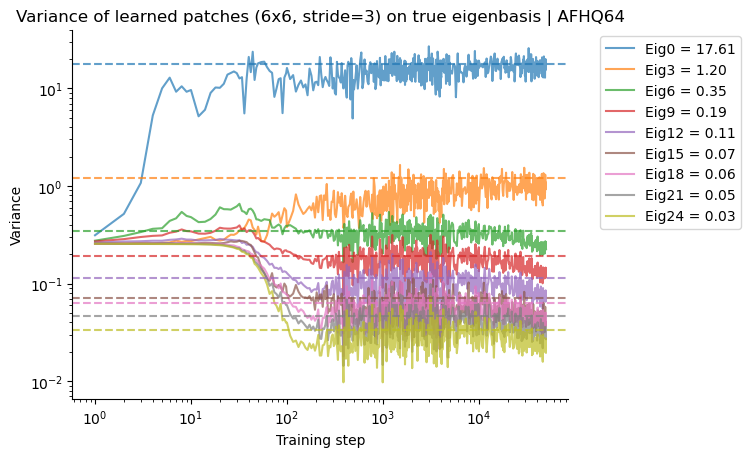

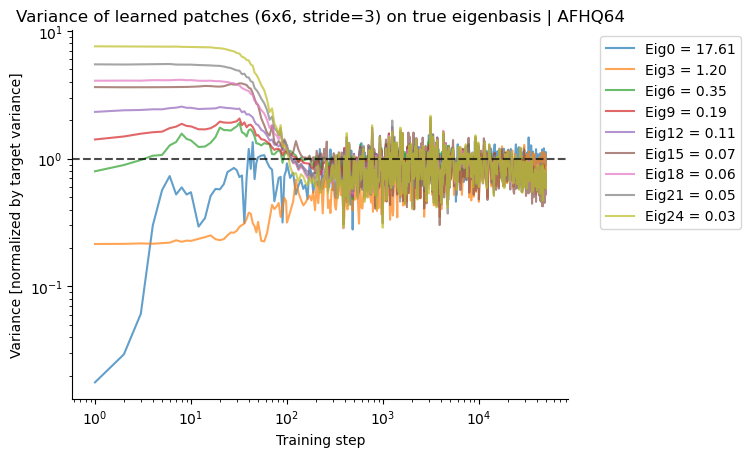

In [107]:
slice2plot = slice(0, 27, 3)
plot_variance_trajectories(step_slice, diag_cov_x_patch_sample_true_eigenbasis_traj, patch_eigval.cpu(), slice2plot,
                            patch_size=patch_size, patch_stride=patch_stride, savedir=savedir, dataset_name="AFHQ64")

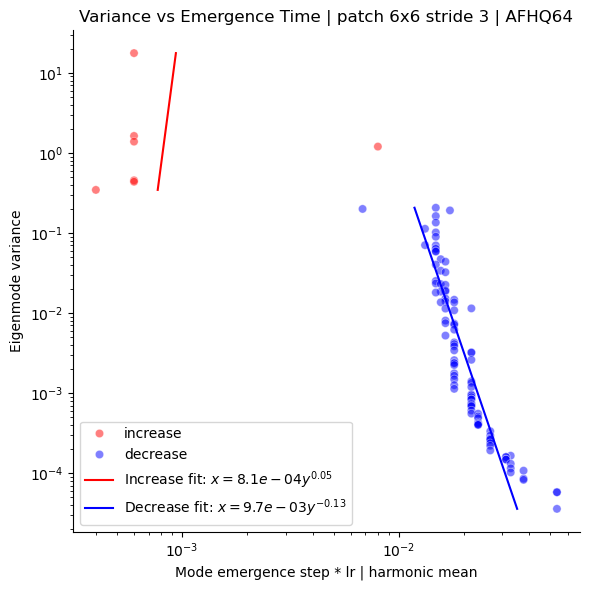

In [108]:
lr = 2e-4
lr_step_slice = np.array(step_slice) * lr
df = compute_crossing_points(patch_eigval, diag_cov_x_patch_sample_true_eigenbasis_traj, lr_step_slice, smooth_sigma=0.1, threshold_type="harmonic_mean", )
df.to_csv(f"{savedir}/synopsis_patch_{patch_size}x{patch_size}_stride_{patch_stride}_eigenmode_emergence_harmonic_mean_vs_variance.csv", index=False)
figh = analyze_and_plot_variance(df, x_col='emergence_step', y_col='Variance', 
                          hue_col='Direction', palette={"increase": "red", "decrease": "blue"}, 
                          log_x=True, log_y=True, figsize=(6, 6), fit_label_format='{direction} fit: $x = {a:.1e}y^{{{b:.2f}}}$', 
                          reverse_equation=True, annotate=False, annotate_offset=(0, 0), title=f'Variance vs Emergence Time | patch {patch_size}x{patch_size} stride {patch_stride} | AFHQ64', 
                          xlabel='Mode emergence step * lr | harmonic mean', ylabel='Eigenmode variance', alpha=0.5, fit_line_kwargs=None, scatter_kwargs=None, ax=None)

saveallforms(savedir, f"synopsis_patch_{patch_size}x{patch_size}_stride_{patch_stride}_eigenmode_emergence_harmonic_mean_vs_variance_fitline_lr_reverse")

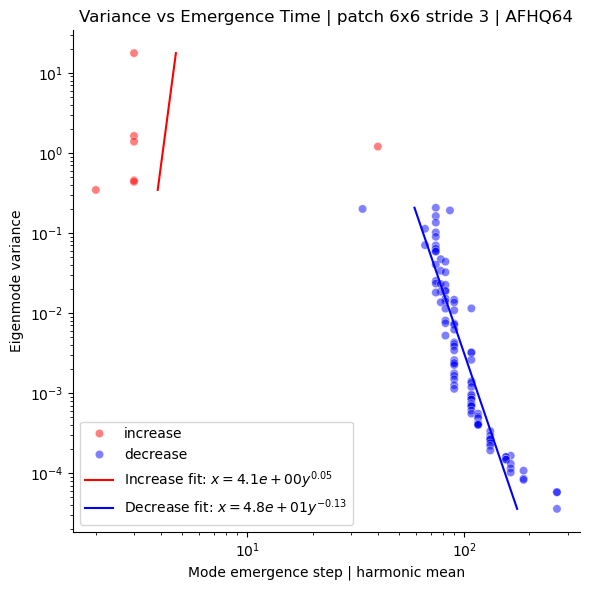

In [109]:
df = compute_crossing_points(patch_eigval, diag_cov_x_patch_sample_true_eigenbasis_traj, step_slice, smooth_sigma=0.1, threshold_type="harmonic_mean", )
df.to_csv(f"{savedir}/synopsis_patch_{patch_size}x{patch_size}_stride_{patch_stride}_eigenmode_emergence_harmonic_mean_vs_variance.csv", index=False)
figh = analyze_and_plot_variance(df, x_col='emergence_step', y_col='Variance', 
                          hue_col='Direction', palette={"increase": "red", "decrease": "blue"}, 
                          log_x=True, log_y=True, figsize=(6, 6), fit_label_format='{direction} fit: $x = {a:.1e}y^{{{b:.2f}}}$', 
                          reverse_equation=True, annotate=False, annotate_offset=(7, 0), title=f'Variance vs Emergence Time | patch {patch_size}x{patch_size} stride {patch_stride} | AFHQ64', 
                          xlabel='Mode emergence step | harmonic mean', ylabel='Eigenmode variance', alpha=0.5, fit_line_kwargs=None, scatter_kwargs=None, ax=None)

saveallforms(savedir, f"synopsis_patch_{patch_size}x{patch_size}_stride_{patch_stride}_eigenmode_emergence_harmonic_mean_vs_variance_fitline_reverse")

#### Patch 9x9 stride 3

In [94]:
patch_size, patch_stride = 9, 3
step_slice = sorted(sample_store.keys())
patch_mean, patch_cov, patch_eigval, patch_eigvec, mean_x_patch_sample_traj, cov_x_patch_sample_traj, diag_cov_x_patch_sample_true_eigenbasis_traj = \
     process_patch_mean_cov_statistics(Xtsr, sample_store, savedir, patch_size=patch_size, patch_stride=patch_stride, device="cuda", imgshape=(3, 64, 64))

patch_cov.shape: torch.Size([243]) computed on 15803 images


  0%|          | 0/494 [00:00<?, ?it/s]

Saved to /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiffusionSpectralLearningCurve/AFHQ_UNet_CNN_EDM_4blocks_wide64_attn_pilot_fixednorm/sample_patch_9x9_stride_3_cov_true_eigenbasis_diag_traj.pkl


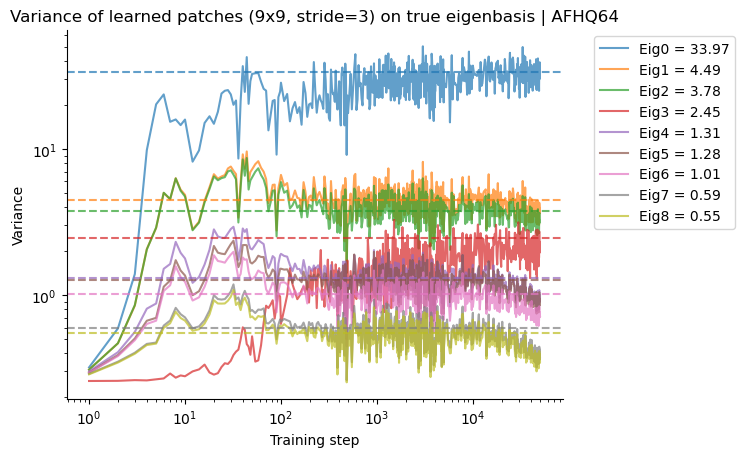

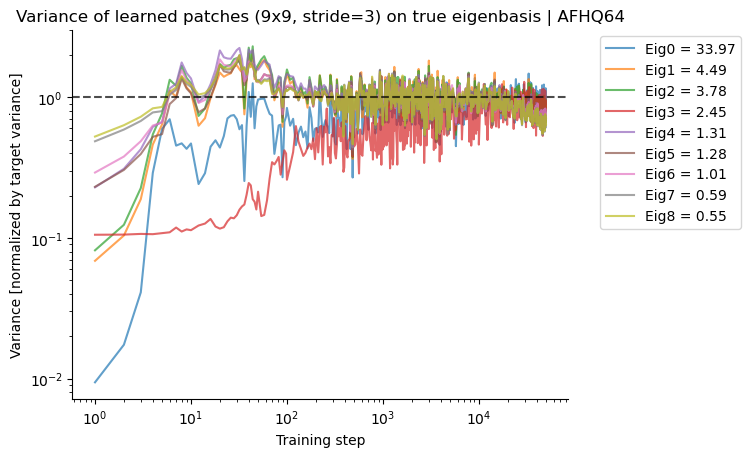

In [95]:
slice2plot = slice(0, 9, 1)
plot_variance_trajectories(step_slice, diag_cov_x_patch_sample_true_eigenbasis_traj, patch_eigval.cpu(), slice2plot,
                            patch_size=patch_size, patch_stride=patch_stride, savedir=savedir, dataset_name="AFHQ64")

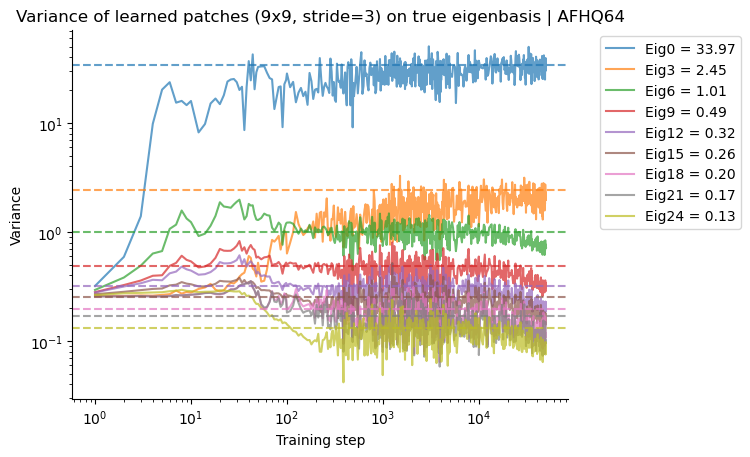

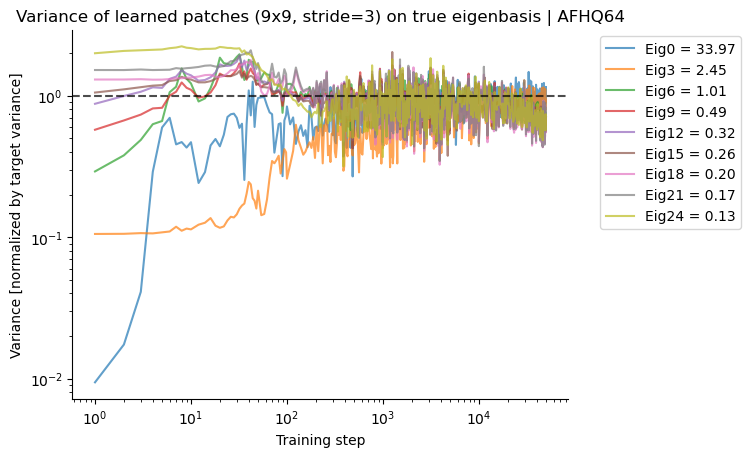

In [96]:
slice2plot = slice(0, 27, 3)
plot_variance_trajectories(step_slice, diag_cov_x_patch_sample_true_eigenbasis_traj, patch_eigval.cpu(), slice2plot,
                            patch_size=patch_size, patch_stride=patch_stride, savedir=savedir, dataset_name="AFHQ64")

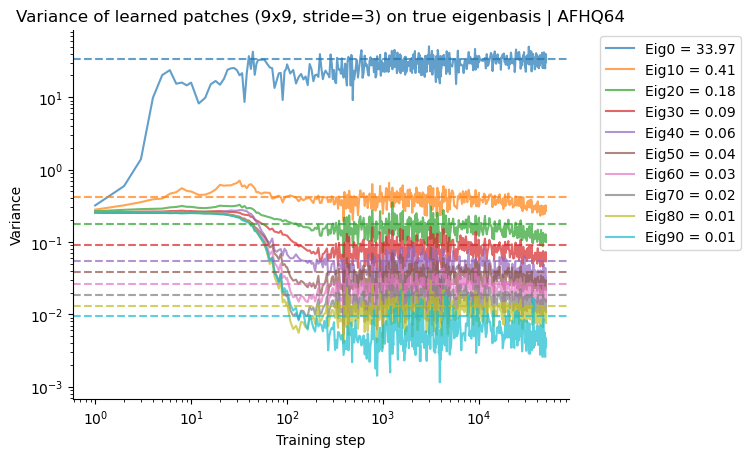

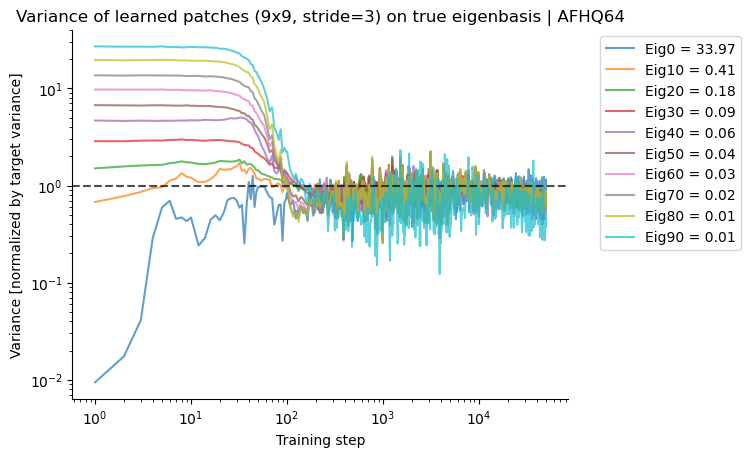

In [97]:
slice2plot = slice(0, 100, 10)
plot_variance_trajectories(step_slice, diag_cov_x_patch_sample_true_eigenbasis_traj, patch_eigval.cpu(), slice2plot,
                            patch_size=patch_size, patch_stride=patch_stride, savedir=savedir, dataset_name="AFHQ64")

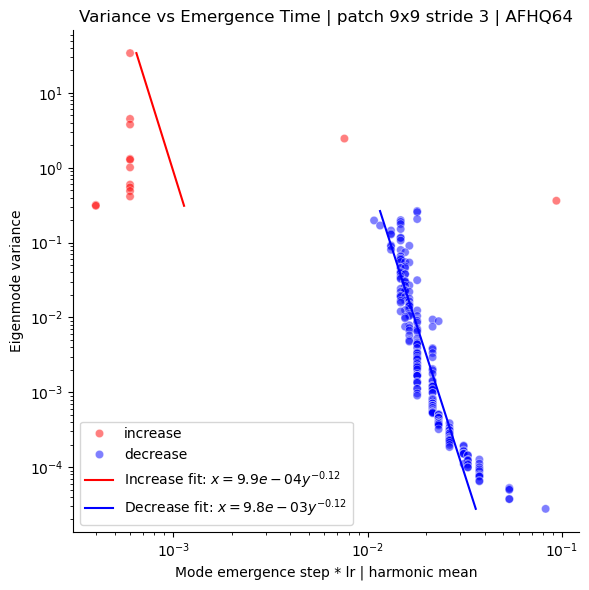

In [98]:
lr = 2e-4
lr_step_slice = np.array(step_slice) * lr
df = compute_crossing_points(patch_eigval, diag_cov_x_patch_sample_true_eigenbasis_traj, lr_step_slice, smooth_sigma=0.1, threshold_type="harmonic_mean", )
df.to_csv(f"{savedir}/synopsis_patch_{patch_size}x{patch_size}_stride_{patch_stride}_eigenmode_emergence_harmonic_mean_vs_variance.csv", index=False)
figh = analyze_and_plot_variance(df, x_col='emergence_step', y_col='Variance', 
                          hue_col='Direction', palette={"increase": "red", "decrease": "blue"}, 
                          log_x=True, log_y=True, figsize=(6, 6), fit_label_format='{direction} fit: $x = {a:.1e}y^{{{b:.2f}}}$', 
                          reverse_equation=True, annotate=False, annotate_offset=(0, 0), title=f'Variance vs Emergence Time | patch {patch_size}x{patch_size} stride {patch_stride} | AFHQ64', 
                          xlabel='Mode emergence step * lr | harmonic mean', ylabel='Eigenmode variance', alpha=0.5, fit_line_kwargs=None, scatter_kwargs=None, ax=None)

saveallforms(savedir, f"synopsis_patch_{patch_size}x{patch_size}_stride_{patch_stride}_eigenmode_emergence_harmonic_mean_vs_variance_fitline_lr_reverse")

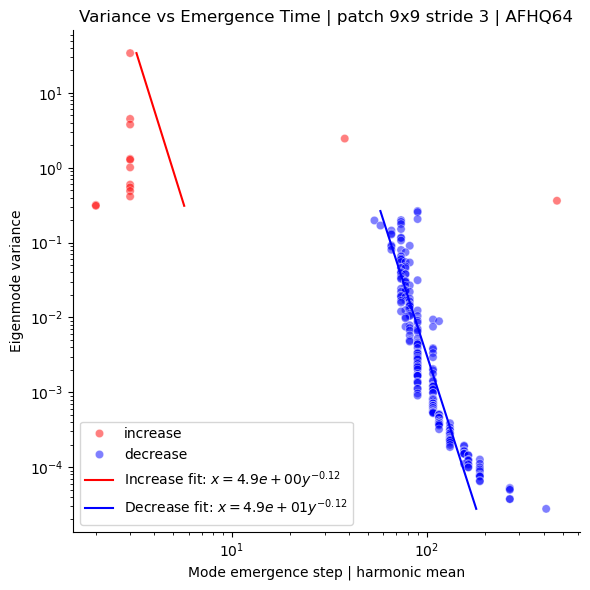

In [99]:
df = compute_crossing_points(patch_eigval, diag_cov_x_patch_sample_true_eigenbasis_traj, step_slice, smooth_sigma=0.1, threshold_type="harmonic_mean", )
df.to_csv(f"{savedir}/synopsis_patch_{patch_size}x{patch_size}_stride_{patch_stride}_eigenmode_emergence_harmonic_mean_vs_variance.csv", index=False)
figh = analyze_and_plot_variance(df, x_col='emergence_step', y_col='Variance', 
                          hue_col='Direction', palette={"increase": "red", "decrease": "blue"}, 
                          log_x=True, log_y=True, figsize=(6, 6), fit_label_format='{direction} fit: $x = {a:.1e}y^{{{b:.2f}}}$', 
                          reverse_equation=True, annotate=False, annotate_offset=(7, 0), title=f'Variance vs Emergence Time | patch {patch_size}x{patch_size} stride {patch_stride} | AFHQ64', 
                          xlabel='Mode emergence step | harmonic mean', ylabel='Eigenmode variance', alpha=0.5, fit_line_kwargs=None, scatter_kwargs=None, ax=None)

saveallforms(savedir, f"synopsis_patch_{patch_size}x{patch_size}_stride_{patch_stride}_eigenmode_emergence_harmonic_mean_vs_variance_fitline_reverse")

### FFHQ

### scratch

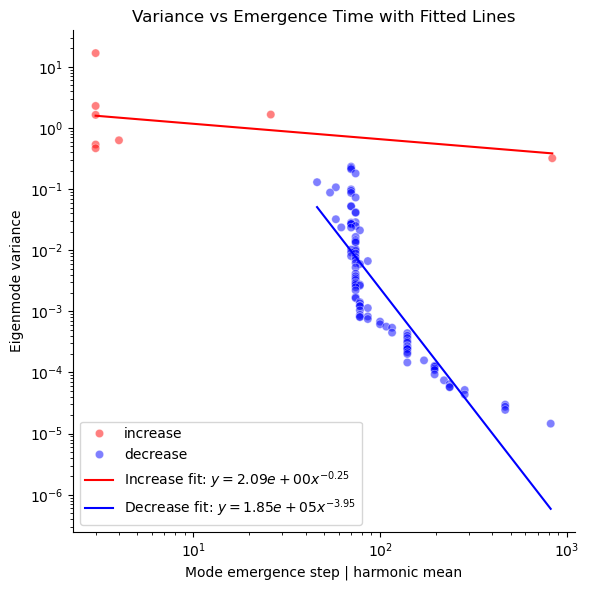

In [52]:
df = compute_crossing_points(patch_eigval, diag_cov_x_patch_sample_true_eigenbasis_traj, step_slice, smooth_sigma=0.1, threshold_type="harmonic_mean", )
df.to_csv(f"{savedir}/synopsis_patch_{patch_size}x{patch_size}_stride_{patch_stride}_eigenmode_emergence_harmonic_mean_vs_variance.csv", index=False)
figh = analyze_and_plot_variance(df, x_col='emergence_step', y_col='Variance', 
                          hue_col='Direction', palette={"increase": "red", "decrease": "blue"}, 
                          log_x=True, log_y=True, figsize=(6, 6), fit_label_format='{direction} fit: $y = {a:.2e}x^{{{b:.2f}}}$', 
                          reverse_equation=False, annotate=False, annotate_offset=(7, 0), title='Variance vs Emergence Time with Fitted Lines', 
                          xlabel='Mode emergence step | harmonic mean', ylabel='Eigenmode variance', alpha=0.5, fit_line_kwargs=None, scatter_kwargs=None, ax=None)

saveallforms(savedir, f"synopsis_patch_{patch_size}x{patch_size}_stride_{patch_stride}_eigenmode_emergence_harmonic_mean_vs_variance_fitline")

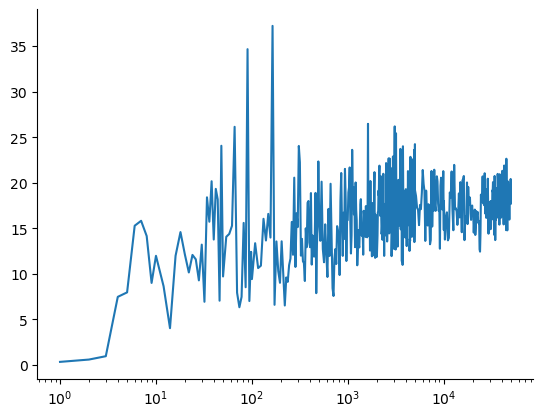

In [42]:
plt.plot(step_slice, diag_cov_x_patch_sample_true_eigenbasis_traj[:,0])
plt.xscale("log")

No crossing found for mode 0
No crossing found for mode 1
No crossing found for mode 3
Not enough data points to fit for direction: nan


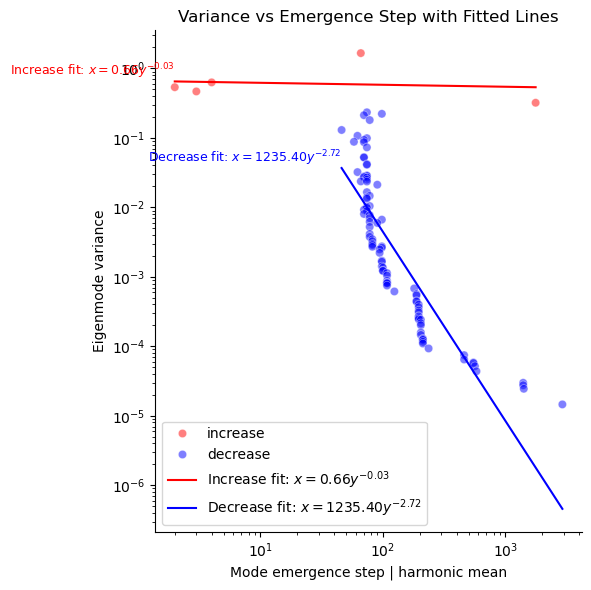

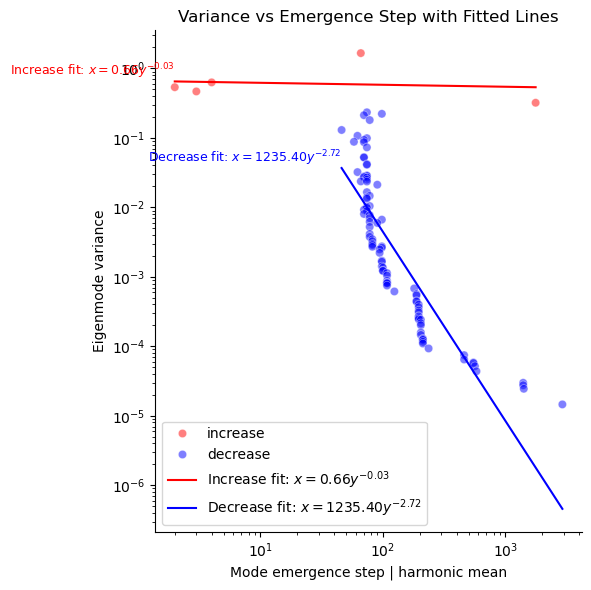

In [35]:
df = compute_crossing_points(patch_eigval, diag_cov_x_patch_sample_true_eigenbasis_traj, step_slice, smooth_sigma=2, threshold_type="harmonic_mean", )
analyze_and_plot_variance(df, x_col='emergence_step', y_col='Variance', 
                          hue_col='Direction', palette={"increase": "red", "decrease": "blue"}, 
                          log_x=True, log_y=True, figsize=(6, 6), fit_label_format='{direction} fit: $x = {a:.2f}y^{{{b:.2f}}}$', 
                          reverse_equation=False, annotate=True, annotate_offset=(0, 0), title='Variance vs Emergence Step with Fitted Lines', 
                          xlabel='Mode emergence step | harmonic mean', ylabel='Eigenmode variance', alpha=0.5, fit_line_kwargs=None, scatter_kwargs=None, ax=None)

In [20]:
patch_size, patch_stride = 6, 3
step_slice = sorted(sample_store.keys())
patch_mean, patch_cov, patch_eigval, patch_eigvec, mean_x_patch_sample_traj, cov_x_patch_sample_traj, diag_cov_x_patch_sample_true_eigenbasis_traj = \
     process_patch_mean_cov_statistics(Xtsr, sample_store, savedir, patch_size=patch_size, patch_stride=patch_stride, device="cuda", imgshape=(3, 32, 32))

patch_cov.shape: torch.Size([108]) computed on 50000 images


  0%|          | 0/494 [00:00<?, ?it/s]

Saved to /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiffusionSpectralLearningCurve/CIFAR10_UNet_CNN_EDM_3blocks_wide128_attn_pilot_fixednorm_smalllr/sample_patch_6x6_stride_3_cov_true_eigenbasis_diag_traj.pkl


No crossing found for mode 0
No crossing found for mode 1
No crossing found for mode 3
Not enough data points to fit for direction: nan


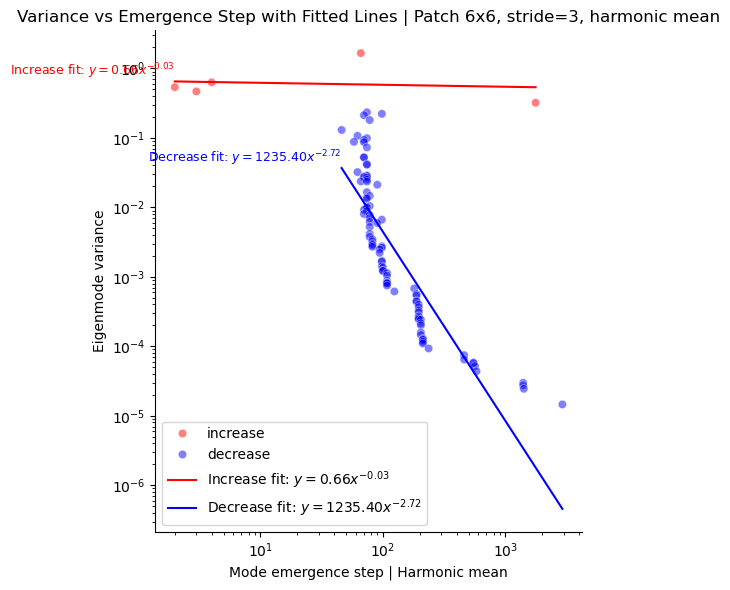

In [ ]:
df = compute_crossing_points(patch_eigval, diag_cov_x_patch_sample_true_eigenbasis_traj, step_slice, smooth_sigma=2, threshold_type="harmonic_mean", )
df.to_csv(f"{savedir}/synopsis_patch_{patch_size}x{patch_size}_stride_{patch_stride}_eigenmode_emergence_harmonic_mean_vs_variance.csv", index=False)
figh = analyze_and_plot_variance(df, x_col='emergence_step', y_col='Variance', 
                          hue_col='Direction', palette={"increase": "red", "decrease": "blue"}, 
                          log_x=True, log_y=True, figsize=(6, 6), fit_label_format='{direction} fit: $y = {a:.2f}x^{{{b:.2f}}}$', 
                          reverse_equation=False, annotate=True, annotate_offset=(0, 0), 
                          title=f'Variance vs Emergence Step with Fitted Lines | Patch {patch_size}x{patch_size}, stride={patch_stride}, harmonic mean', 
                          xlabel='Mode emergence step | Harmonic mean', ylabel='Eigenmode variance', 
                          alpha=0.5, fit_line_kwargs=None, scatter_kwargs=None, ax=None)
# sns.scatterplot(data=df, x="emergence_step", y="Variance", hue="Direction", palette={"increase": "red", "decrease": "blue"})
# plt.xscale("log")
# plt.yscale("log")
# plt.xlabel("Mode emergence step | harmonic mean")
# plt.ylabel("Eigenvalue")
# plt.title(f"Emergence time of eigenmode in generated distribution vs true variance")
saveallforms(savedir, f"synopsis_patch_{patch_size}x{patch_size}_stride_{patch_stride}_eigenmode_emergence_harmonic_mean_vs_variance_fitline", figh=figh)
plt.show()